# Bonds and clusters

## Importing packages

In [9]:
# Importing necessary packages:
from glob import glob
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

from polyphys.visualize import plotter
from polyphys.visualize.plotter import PROJECT_DETAILS as PD
from polyphys.visualize.plotter import PROPERTY_LABELS as PL
from polyphys.visualize.plotter import ATTRIBUTE_LABELS as AL
from polyphys.visualize.plotter import AMIRHSI_COLORS as AC
from polyphys.visualize.plotter import DUTCH_FEILD_COLORS as DF_colors
from polyphys.visualize import tuner
from polyphys.manage.parser import \
    SumRuleCyl, TransFociCyl, TransFociCub, HnsCub
from polyphys.manage import organizer
dmon_large_c_palette = ['orange', 'darkgoldenrod', 'forestgreen']

## Per geometry:

### Merging bonds and cluster data

In [ ]:
hist_properties = ['clustersHistFoci', 'bondsHistFoci']
#hist_names = dict(zip(hist_properties, ['clusters', 'bonds']))
measures = ['mean', 'sem', 'var']
species = 'Foci'
bin_center_labels = {
   'clustersHistFoci': '$x_c$',
   'bondsHistFoci': '$x_d$'
}
phase = 'ensAvg'
foci = []
# Project details
#project = 'HnsCub'
project = 'TransFociCub'
#project = 'SumRuleCyl'
#project = 'TransFociCub'
# loading databases:
allInOne_db = '../../Datasets/'+project+'-allInOne/' # relative
for prop in hist_properties:
    cols_to_drop = [prop + '-' + measure for measure in  measures]
    AL['bin_center'] = bin_center_labels[prop]
    hist_df = '-'.join(['allInOne', project, PD[project]['group'], prop + '.parquet.brotli'])
    hist_df = allInOne_db + hist_df
    hist_df = pd.read_parquet(hist_df)
    hist_df.drop(columns=cols_to_drop, inplace=True)
    # phi_c to drop
    phi_c_to_drop = [0.025, 0.05, 0.075, 0.125, 0.175]
    hist_df = hist_df.loc[~hist_df['phi_c_bulk_round'].isin(phi_c_to_drop),:]
    #hist_df.reset_index(inplace=True, drop=True)
    hist_df['property'] = prop
    hist_df.rename(columns={prop + '-norm': 'value'}, inplace=True)
    foci.append(hist_df)
foci =  pd.concat(foci, axis=0)
# a sorted list of unique spaces in the dataset
spaces = hist_df['space'].unique()
spaces = sorted(spaces, key = organizer.sort_by_alphanumeric)
project_titles = {}
for space in spaces:
    s_info = PD[project]['parser'](
        space,
        'space',
        PD[project]['geometry'],
        PD[project]['group'],
        PD[project]['topology'],
        ispath=False
    )
    if project == 'TransFociCub':
        project_title_style = (fr"$N_m={s_info.nmon_small},$ " +
                             fr"$N_M={s_info.nmon_large},$ " +
                             fr"${{a_c}}/{{a_m}}={s_info.dcrowd}$")
    elif project == 'TransFociCyl':
        project_title_style = (fr"$N_m={s_info.nmon_small},$ " +
                             fr"$N_M={s_info.nmon_large},$ " +
                             fr"${{D}}/{{a_m}}={s_info.dcyl},$ " +
                             fr"${{a_c}}/{{a_m}}={s_info.dcrowd}$")
    elif project == 'SumRuleCyl':
        project_title_style = (fr"$N={s_info.nmon},$ " +
                             fr"$D={s_info.dcyl},$ " +
                             fr"$a_c={s_info.dcrowd}$")
    elif project == 'HnsCub':
        project_title_style = (fr"$N={s_info.nmon},$ " +
                             fr"$N_{{hns}}={s_info.nhns},$ " +
                             fr"a_c={s_info.dcrowd}$")
    else:
        raise ValueError(f"Project: '{project}' is not defined.")
    project_titles[project] = project_title_style

###  phi_c as row, dmon_large as hue

In [ ]:
height = 3
aspect = 1.5 * 1.618 # Golden ratio
font_scale = 1.2
font_family = 'sans-serif' # 'Times New Roman'
plot_context = 'talk'
color_palette = dmon_large_c_palette
save_to = './'
ext = 'pdf'
font_family = 'sans-serif' # 'Times New Roman'
rc_params = {
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': True,
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': False,
    'sharex': 'row',
    'legend_out': True
}
legend_kws = {
    'ncol': 3,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0.2,
    'handletextpad': 0.1,
    'edgecolor': 'black',
    'markerscale': 1
}
global_bbox = dict(boxstyle="round",ec='black',fc='none',linewidth=1)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)
fig_title_kws = {'x': 0.45, 'y': 0.96, 'ha': 'center'}
sns.set_theme(
        context=plot_context,
        style='ticks',
        palette=color_palette,
        font=font_family,
        font_scale=font_scale,
        rc=rc_params
    )

phi_c_bulk_cond = (foci['phi_c_bulk_round'].isin([0.1, 0.2, 0.3, 0.4]))
conds = phi_c_bulk_cond
foci_filtered = foci.loc[conds,:]
foci_filtered.reset_index(drop=True, inplace=True)
nmon_large = foci_filtered['nmon_large'].unique()[0]
data = foci_filtered

x_prop = 'bin_center'
y_prop = 'value'
col_attr = 'property'
col_order = sorted(data[col_attr].unique())
row_attr = 'phi_c_bulk_round'
row_order = sorted(data[row_attr].unique())
hue_attr = 'dmon_large'
hue_order = sorted(data[hue_attr].unique())

sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font=font_family,
    font_scale=font_scale,
    rc=rc_params
)
tseries_grid = sns.catplot(
    data=data,
    x=x_prop,
    y=y_prop,
    col=col_attr,
    col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    height=height,
    aspect=aspect,
    palette=color_palette,
    legend='full',
    sharey=False,
    sharex=False,
    kind='point',
    dodge=0.05
)
tseries_grid.set_titles('')
row_col_pairs = list(itertools.product(row_order,col_order))
for idx, (ax, (row_name, col_name)) in enumerate(zip(tseries_grid.axes.flat,row_col_pairs)):
    if idx == 1:
        ax.legend(
            title=AL[hue_attr],
            loc='center right',
            #bbox_to_anchor=(0.85,0.70),
            **legend_kws
        )
    ax.set_ylabel(PL[project][col_name+'-norm']['symbol'])
    ax.text(0.85,0.92, AL[row_attr] + fr"$={row_name}$",
            color='black',
            ha="center",
            va="center",
            bbox=global_bbox,
            transform=ax.transAxes)
    if idx >= (len(row_col_pairs) - len(col_order)):
        ax.set_xlabel(bin_center_labels[col_name])
    else:
        ax.axes.xaxis.set_ticklabels([])
tseries_grid.set(yticks=np.arange(0,1.2,0.2))
tseries_grid.fig.suptitle(project_titles[project], **fig_title_kws)
tseries_grid.tight_layout(w_pad=0.5, h_pad=0.2)
tseries_grid._legend.remove()
output = "-".join(['Clustering',row_attr, hue_attr,PD[project]['geometry_name'],PD[project]['chain_name']])
tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
plt.close()

### phi_c as hue, dmon_large as row

In [ ]:
height = 3
aspect = 1.5 * 1.618 # Golden ratio
font_scale = 1.2
font_family = 'sans-serif' # 'Times New Roman'
plot_context = 'talk'
color_palette = 'rocket_r'
save_to = './'
ext = 'pdf'
font_family = 'sans-serif' # 'Times New Roman'
rc_params = {
    'mathtext.default': 'regular',
    'text.usetex': True,
}
facet_kws = {
    'sharey': False,
    'sharex': 'row',
    'legend_out': True
}
legend_kws = {
    'ncol': 1,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0.2,
    'handletextpad': 0.1,
    'edgecolor': 'black',
    'markerscale': 1
}
global_bbox = dict(boxstyle="round",ec='black',fc='none',linewidth=1)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)
fig_title_kws = {'x': 0.45, 'y': 0.95, 'ha': 'center'}
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font=font_family,
    font_scale=font_scale,
    rc=rc_params
)
#foci_filtered = foci#.loc[conds,:]
#foci_filtered.reset_index(drop=True, inplace=True)
data = foci
x_prop = 'bin_center'
y_prop = 'value'
col_attr = 'property'
col_order = sorted(data[col_attr].unique())
row_attr = 'dmon_large'
row_order = sorted(data[row_attr].unique())
hue_attr = 'phi_c_bulk_round'
hue_order = sorted(data[hue_attr].unique())
tseries_grid = sns.catplot(
    data=data,
    x=x_prop,
    y=y_prop,
    col=col_attr,
    col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    height=height,
    aspect=aspect,
    palette=color_palette,
    legend='full',
    sharey=False,
    sharex=False,
    kind='point',
    dodge=0.05
)
tseries_grid.set_titles("")
row_col_pairs = list(itertools.product(row_order,col_order))
xlims = {
    'bondsHistFoci': [0, nmon_large-1],
    'clustersHistFoci': [1, nmon_large]
}
for idx, (ax, (row_name, col_name)) in enumerate(zip(tseries_grid.axes.flat,row_col_pairs)):
    ax.set_ylabel(PL[project][col_name+'-norm']['symbol'])
    ax.text(0.75,0.8, AL[row_attr] + fr"$={row_name}$",
            color='black',
            ha="center",
            va="center",
            bbox=global_bbox,
            transform=ax.transAxes)
    if idx >= (len(row_col_pairs) - len(col_order)):
        ax.set_xlabel(bin_center_labels[col_name])
    else:
        ax.axes.xaxis.set_ticklabels([])
tseries_grid.set(yticks=np.arange(0,1.2,0.2))
tseries_grid._legend.remove()
tseries_grid.add_legend(
    title=AL[hue_attr],
    loc='center right',
    **legend_kws)
tseries_grid.fig.suptitle(project_titles[project], **fig_title_kws)
tseries_grid.tight_layout(w_pad=0.2, h_pad=0.1)
output = "-".join(['Clustering',row_attr, hue_attr,PD[project]['geometry_name'],PD[project]['chain_name']])
tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
plt.close()

## All geometries

### Merging projects

In [2]:
hist_properties = ['clustersHistFoci', 'bondsHistFoci']
#hist_names = dict(zip(hist_properties, ['clusters', 'bonds']))
measures = ['mean', 'sem', 'var']
species = 'Foci'
bin_center_labels = {
   'clustersHistFoci': '$x_c$',
   'bondsHistFoci': '$x_d$'
}
geometry_name = {
    'TransFociCub': 'Free Space',
    'TransFociCyl': 'Cylindrical confinement',
}
phase = 'ensAvg'
foci = []
project_titles = {}
projects_comon_title = ''
# Project details
#project = 'HnsCub'
project = 'TransFociCub'
#project = 'SumRuleCyl'
#project = 'TransFociCub'
# loading databases:
projects = ['TransFociCyl', 'TransFociCub']
for project in projects:
    allInOne_db = '../../Datasets/'+project+'-allInOne/' # relative
    for prop in hist_properties:
        cols_to_drop = [prop + '-' + measure for measure in  measures]
        AL['bin_center'] = bin_center_labels[prop]
        hist_df = '-'.join(['allInOne', project, PD[project]['group'], prop + '.parquet.brotli'])
        hist_df = allInOne_db + hist_df
        hist_df = pd.read_parquet(hist_df)
        hist_df['geometry'] = geometry_name[project]
        hist_df.drop(columns=cols_to_drop, inplace=True)
        # phi_c to drop
        phi_c_to_drop = [0.025, 0.05, 0.075, 0.125, 0.175]
        hist_df = hist_df.loc[~hist_df['phi_c_bulk_round'].isin(phi_c_to_drop),:]
        #hist_df.reset_index(inplace=True, drop=True)
        hist_df['property'] = prop
        hist_df.rename(columns={prop + '-norm': 'value'}, inplace=True)
        foci.append(hist_df)
        # a sorted list of unique spaces in the dataset
        spaces = hist_df['space'].unique()
        spaces = sorted(spaces, key = organizer.sort_by_alphanumeric)
        for space in spaces:
            s_info = PD[project]['parser'](
                space,
                'space',
                PD[project]['geometry'],
                PD[project]['group'],
                PD[project]['topology'],
                ispath=False
            )
            if s_info.dmon_large == 5.0:
                projects_comon_title = (
                    fr"$N_m={s_info.nmon_small},$ " +
                    fr"$N_M={s_info.nmon_large},$ " +
                    fr"${{a_M}}/{{a_m}}={s_info.dmon_large},$ " +
                    fr"${{a_c}}/{{a_m}}={s_info.dcrowd}$"
                )
            if project == 'TransFociCub':
                project_title_style = (fr"$N_m={s_info.nmon_small},$ " +
                                       fr"$N_M={s_info.nmon_large},$ " +
                                       fr"${{a_c}}/{{a_m}}={s_info.dcrowd}$")
            elif project == 'TransFociCyl':
                project_title_style = (fr"$N_m={s_info.nmon_small},$ " +
                                       fr"$N_M={s_info.nmon_large},$ " +
                                       fr"${{D}}/{{a_m}}={s_info.dcyl},$ " +
                                       fr"${{a_c}}/{{a_m}}={s_info.dcrowd}$")
            else:
                raise ValueError(f"Project: '{project}' is not defined.")
        project_titles[project] = project_title_style
foci =  pd.concat(foci, axis=0)

In [6]:
foci

,bin_center,bin_center-norm,value,space,ensemble_long,ensemble,nmon_small,nmon_large,dmon_large,dcyl,dcrowd,phi_c_bulk,phi_c_bulk_round,geometry,property
0,1,0.20,9.771383e-01,ns400nl5al5.0D20.0ac1.0,epss5epsl5r10.5al5nl5ml125ns400ac1nc0lz77dt0.0...,ns400nl5al5.0D20.0ac1.0nc0,400,5,5.0,20.0,1.0,0.000000,0.0,Cylindrical confinement,clustersHistFoci
1,2,0.40,2.258185e-02,ns400nl5al5.0D20.0ac1.0,epss5epsl5r10.5al5nl5ml125ns400ac1nc0lz77dt0.0...,ns400nl5al5.0D20.0ac1.0nc0,400,5,5.0,20.0,1.0,0.000000,0.0,Cylindrical confinement,clustersHistFoci
2,3,0.60,2.782893e-04,ns400nl5al5.0D20.0ac1.0,epss5epsl5r10.5al5nl5ml125ns400ac1nc0lz77dt0.0...,ns400nl5al5.0D20.0ac1.0nc0,400,5,5.0,20.0,1.0,0.000000,0.0,Cylindrical confinement,clustersHistFoci
3,4,0.80,1.534684e-06,ns400nl5al5.0D20.0ac1.0,epss5epsl5r10.5al5nl5ml125ns400ac1nc0lz77dt0.0...,ns400nl5al5.0D20.0ac1.0nc0,400,5,5.0,20.0,1.0,0.000000,0.0,Cylindrical confinement,clustersHistFoci
4,5,1.00,0.000000e+00,ns400nl5al5.0D20.0ac1.0,epss5epsl5r10.5al5nl5ml125ns400ac1nc0lz77dt0.0...,ns400nl5al5.0D20.0ac1.0nc0,400,5,5.0,20.0,1.0,0.000000,0.0,Cylindrical confinement,clustersHistFoci
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0,0.00,9.869813e-01,ns400nl5al3.0ac1.0,al3nl5ml27ns400ac1nc241717l37.5dt0.005bdump200...,ns400nl5al3.0ac1.0nc241717,400,5,3.0,NaN,1.0,0.300001,0.3,Free Space,bondsHistFoci
176,1,0.25,1.299524e-02,ns400nl5al3.0ac1.0,al3nl5ml27ns400ac1nc241717l37.5dt0.005bdump200...,ns400nl5al3.0ac1.0nc241717,400,5,3.0,NaN,1.0,0.300001,0.3,Free Space,bondsHistFoci
177,2,0.50,2.299954e-05,ns400nl5al3.0ac1.0,al3nl5ml27ns400ac1nc241717l37.5dt0.005bdump200...,ns400nl5al3.0ac1.0nc241717,400,5,3.0,NaN,1.0,0.300001,0.3,Free Space,bondsHistFoci
178,3,0.75,4.999900e-07,ns400nl5al3.0ac1.0,al3nl5ml27ns400ac1nc241717l37.5dt0.005bdump200...,ns400nl5al3.0ac1.0nc241717,400,5,3.0,NaN,1.0,0.300001,0.3,Free Space,bondsHistFoci


### geometry as marker shape, phi_c as row, dmon_large as hue

In [5]:
height = 3
aspect = 1.5 * 1.618 # Golden ratio
font_scale = 1.2
font_family = 'sans-serif' # 'Times New Roman'
plot_context = 'talk'
color_palette = dmon_large_c_palette
save_to = './'
ext = 'pdf'
font_family = 'sans-serif' # 'Times New Roman'
rc_params = {
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': True,
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': False,
    'sharex': False,
    'legend_out': True
}
legend_kws = {
    'ncol': 1,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'edgecolor': 'black',
    'markerscale': 1
}
global_bbox = dict(boxstyle="round",ec='black',fc='none',linewidth=1)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)
fig_title_kws = {'x': 0.45, 'y': 0.96, 'ha': 'center'}
sns.set_theme(
        context=plot_context,
        style='ticks',
        palette=color_palette,
        font=font_family,
        font_scale=font_scale,
        rc=rc_params
    )

phi_c_bulk_cond = (foci['phi_c_bulk_round'].isin([0.1, 0.2, 0.3, 0.4]))
conds = phi_c_bulk_cond
foci_filtered = foci.loc[conds,:]
foci_filtered.reset_index(drop=True, inplace=True)
nmon_large = foci_filtered['nmon_large'].unique()[0]
data = foci_filtered

x_prop = 'bin_center'
y_prop = 'value'
col_attr = 'property'
col_order = sorted(data[col_attr].unique())
row_attr = 'phi_c_bulk_round'
row_order = sorted(data[row_attr].unique())
hue_attr = 'dmon_large'
hue_order = sorted(data[hue_attr].unique())
style_attr = 'geometry'
style_order = list(geometry_name.values())

sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font=font_family,
    font_scale=font_scale,
    rc=rc_params
)
tseries_grid = sns.relplot(
    data=data,
    x=x_prop,
    y=y_prop,
    col=col_attr,
    col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    style=style_attr,
    style_order=style_order,
    height=height,
    aspect=aspect,
    palette=color_palette,
    legend='full',
    kind='line',
    markers=True,
    dashes=False,
    markersize=15,
    alpha=0.7,
    facet_kws=facet_kws
)
tseries_grid.set_titles('')
legend_labels = [AL[hue_attr]] + list(hue_order)  + \
        [AL[style_attr]] + list(style_order)
for idx, new_label in enumerate(legend_labels):
    tseries_grid._legend.texts[idx].set_text(new_label)
sns.move_legend(
    tseries_grid,
    loc='upper left',
    bbox_to_anchor=(0.78,0.70),
    **legend_kws
)
row_col_pairs = list(itertools.product(row_order,col_order))
for idx, (ax, (row_name, col_name)) in enumerate(zip(tseries_grid.axes.flat,row_col_pairs)):
    #if idx == 1:
      #  ax.legend(
      #      title=AL[hue_attr],
      #      loc='center right',
            #bbox_to_anchor=(0.85,0.70),
     #       **legend_kws
    #    )
    ax.set_ylabel(PL[col_name+'-norm']['symbol'])
    ax.text(0.85,0.92, AL[row_attr] + fr"$={row_name}$",
            color='black',
            ha="center",
            va="center",
            bbox=global_bbox,
            transform=ax.transAxes)
    if idx >= (len(row_col_pairs) - len(col_order)):
        ax.set_xlabel(bin_center_labels[col_name])
    else:
        ax.axes.xaxis.set_ticklabels([])
tseries_grid.set(yticks=np.arange(0,1.2,0.2))
tseries_grid.fig.suptitle(project_titles[project], **fig_title_kws)
tseries_grid.tight_layout(w_pad=0.5, h_pad=0.2)
tseries_grid.set(yticks=np.arange(0, 1.2, 0.2))
output = "-".join(['Clustering',row_attr, hue_attr,'free_and_confined',PD[projects[0]]['chain_name']])
tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
plt.close()

### geometry as hue, phi_c as row, dmon_large=5.0

In [ ]:
height = 2.5
aspect =2 * 1.618 # Golden ratio
font_scale = 1.2
font_family = 'sans-serif' # 'Times New Roman'
plot_context = 'talk'
color_palette = AC
save_to = './'
ext = 'pdf'
font_family = 'sans-serif' # 'Times New Roman'
rc_params = {
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': True,
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': False,
    'sharex': False,
    'legend_out': True
}
legend_kws = {
    'ncol': 1,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'edgecolor': 'black',
    'markerscale': 1
}
global_bbox = dict(boxstyle="round",ec='black',fc='none',linewidth=1)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)
fig_title_kws = {'x': 0.45, 'y': 0.97, 'ha': 'center'}
sns.set_theme(
        context=plot_context,
        style='ticks',
        palette=color_palette,
        font=font_family,
        font_scale=font_scale,
        rc=rc_params
    )

phi_c_bulk_cond = (foci['phi_c_bulk_round'].isin([0.2, 0.275, 0.3, 0.325, 0.4]))
dmon_large_cond = (foci['dmon_large'].isin([5.0]))
conds = phi_c_bulk_cond & dmon_large_cond
foci_filtered = foci.loc[conds,:]
foci_filtered.reset_index(drop=True, inplace=True)
nmon_large = foci_filtered['nmon_large'].unique()[0]
data = foci_filtered

x_prop = 'bin_center'
y_prop = 'value'
col_attr = 'property'
col_order = sorted(data[col_attr].unique())
row_attr = 'phi_c_bulk_round'
row_order = sorted(data[row_attr].unique())
hue_attr = 'geometry'
hue_order = list(geometry_name.values())
style_attr = 'geometry'
style_order = list(geometry_name.values())

sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font=font_family,
    font_scale=font_scale,
    rc=rc_params
)
tseries_grid = sns.relplot(
    data=data,
    x=x_prop,
    y=y_prop,
    col=col_attr,
    col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    style=style_attr,
    style_order=style_order,
    height=height,
    aspect=aspect,
    palette=color_palette,
    legend='full',
    kind='line',
    markers=True,
    dashes=False,
    markersize=15,
    alpha=0.7,
    facet_kws=facet_kws
)
tseries_grid.set_titles('')
row_col_pairs = list(itertools.product(row_order,col_order))
for idx, (ax, (row_name, col_name)) in enumerate(zip(tseries_grid.axes.flat,row_col_pairs)):
    ax.set_ylabel(PL[project][col_name+'-norm']['symbol'])
    ax.text(0.83,0.98, AL[row_attr] + fr"$={row_name}$",
            color='black',
            ha="center",
            va="center",
            bbox=global_bbox,
            transform=ax.transAxes)
    if idx >= (len(row_col_pairs) - len(col_order)):
        ax.set_xlabel(bin_center_labels[col_name])
    else:
        ax.axes.xaxis.set_ticklabels([])
tseries_grid.set(yticks=np.arange(0,1.2,0.2))
tseries_grid.fig.suptitle(projects_comon_title, **fig_title_kws)
tseries_grid.tight_layout(w_pad=0.5, h_pad=0.2)
tseries_grid.set(yticks=np.arange(0, 1.2, 0.2))
sns.move_legend(
    tseries_grid,
    title=AL[hue_attr],
    loc='upper left',
    bbox_to_anchor=(0.59,0.895),
    **legend_kws
)
output = "-".join(['Clustering',row_attr, hue_attr,'free_and_confined',PD[projects[0]]['chain_name']])
tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
plt.close()

### dmon_large as hue, phi_c as row, per property

KeyError: 'Free Space-norm'

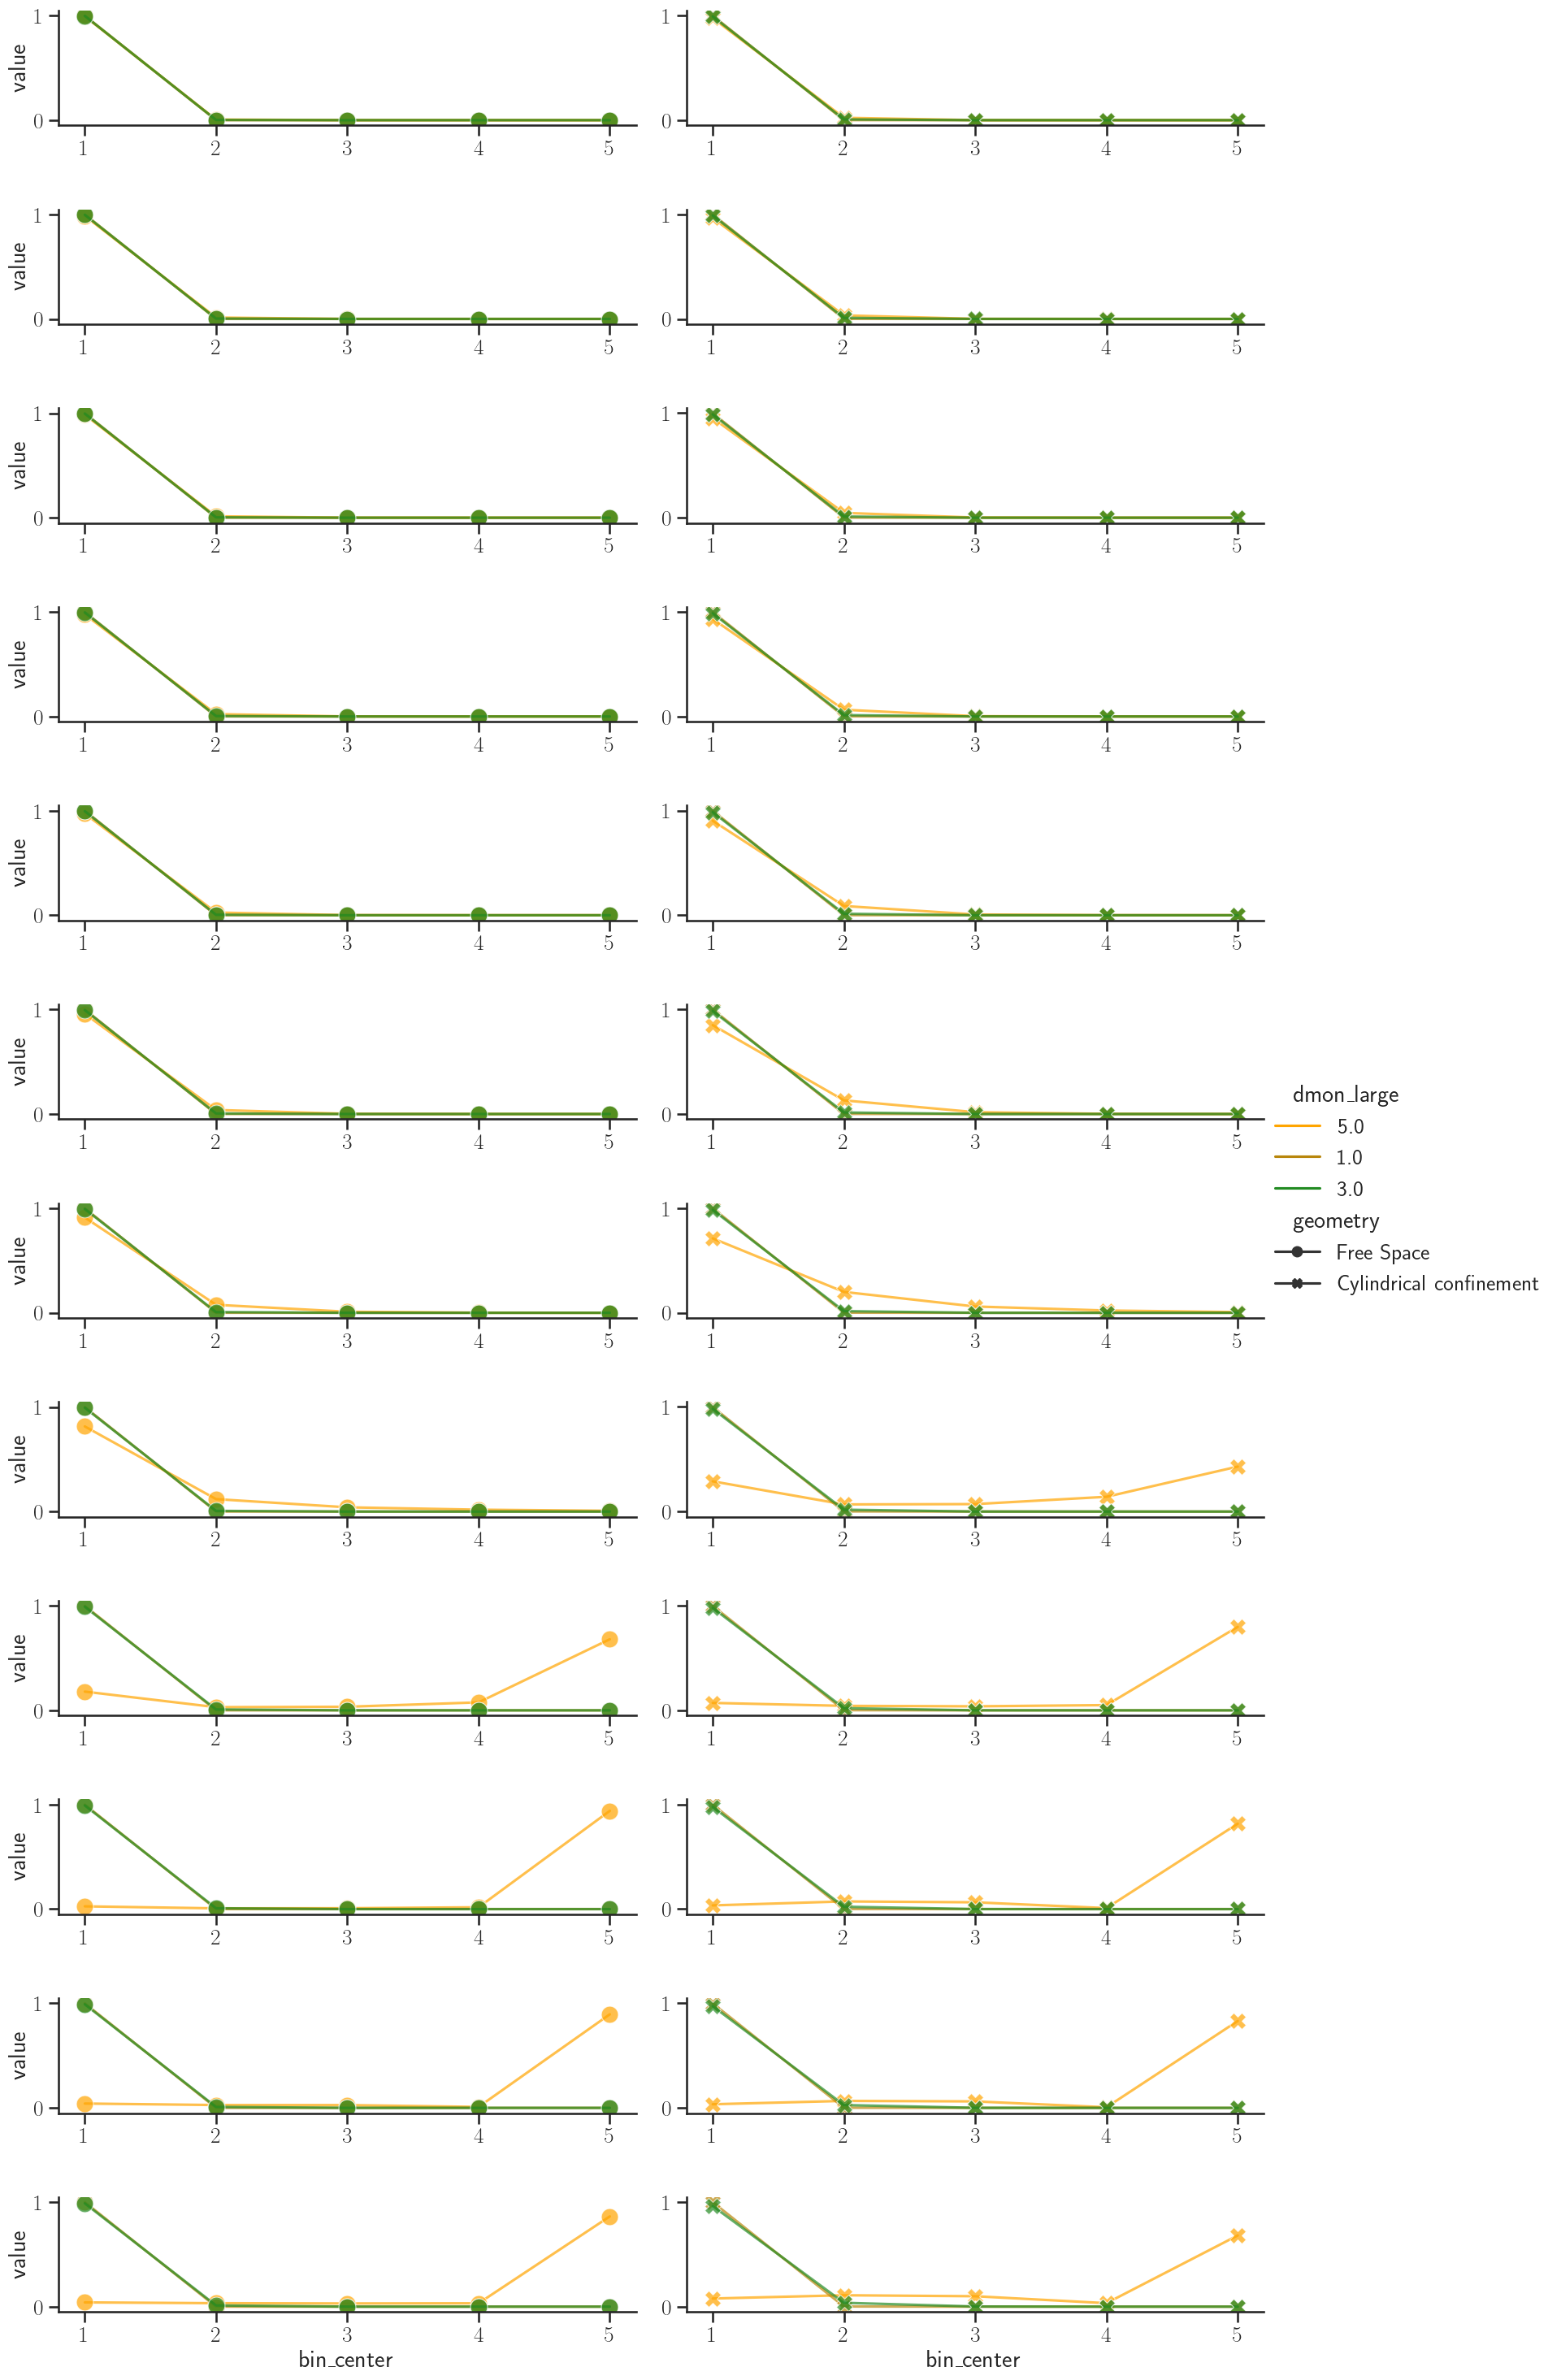

In [14]:
height = 2.5
aspect =2 * 1.618 # Golden ratio
font_scale = 1.2
font_family = 'sans-serif' # 'Times New Roman'
plot_context = 'talk'
color_palette = dmon_large_c_palette
save_to = './'
ext = 'pdf'
font_family = 'sans-serif' # 'Times New Roman'
rc_params = {
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': True,
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': False,
    'sharex': False,
    'legend_out': True
}
legend_kws = {
    'ncol': 1,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'edgecolor': 'black',
    'markerscale': 1
}
global_bbox = dict(boxstyle="round",ec='black',fc='none',linewidth=1)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)
fig_title_kws = {'x': 0.45, 'y': 0.97, 'ha': 'center'}
sns.set_theme(
        context=plot_context,
        style='ticks',
        palette=color_palette,
        font=font_family,
        font_scale=font_scale,
        rc=rc_params
    )

phi_c_bulk_cond = (foci['phi_c_bulk_round'].isin([0.2, 0.275, 0.3, 0.325, 0.4]))
#dmon_large_cond = (foci['dmon_large'].isin([5.0]))
for prop in foci['property'].unique():
    prop_cond = (foci['property'] == prop)
    conds = prop_cond #&phi_c_bulk_cond & dmon_large_cond
    foci_filtered = foci.loc[conds,:]
    foci_filtered.reset_index(drop=True, inplace=True)
    nmon_large = foci_filtered['nmon_large'].unique()[0]
    x_prop = 'bin_center'
    y_prop = 'value'
    col_attr = 'geometry'
    col_order = list(geometry_name.values())
    sorted(foci_filtered[col_attr].unique())
    row_attr = 'phi_c_bulk_round'
    row_order = sorted(foci_filtered[row_attr].unique())
    hue_attr = 'dmon_large'
    hue_order = list(foci_filtered[hue_attr].unique())
    sns.set_theme(
        context=plot_context,
        style='ticks',
        palette=color_palette,
        font=font_family,
        font_scale=font_scale,
        rc=rc_params
    )
    tseries_grid = sns.relplot(
        data=foci_filtered,
        x=x_prop,
        y=y_prop,
        col=col_attr,
        col_order=col_order,
        row=row_attr,
        row_order=row_order,
        hue=hue_attr,
        hue_order=hue_order,
        style=style_attr,
        style_order=style_order,
        height=height,
        aspect=aspect,
        palette=color_palette,
        legend='full',
        kind='line',
        markers=True,
        dashes=False,
        markersize=15,
        alpha=0.7,
        facet_kws=facet_kws
    )
    tseries_grid.set_titles('')
    row_col_pairs = list(itertools.product(row_order,col_order))
    for idx, (ax, (row_name, col_name)) in enumerate(zip(tseries_grid.axes.flat,row_col_pairs)):
        ax.set_ylabel(PL[col_name+'-norm']['symbol'])
        ax.text(0.83,0.98, AL[row_attr] + fr"$={row_name}$",
                color='black',
                ha="center",
                va="center",
                bbox=global_bbox,
                transform=ax.transAxes)
        if idx >= (len(row_col_pairs) - len(col_order)):
            ax.set_xlabel(bin_center_labels[col_name])
        else:
            ax.axes.xaxis.set_ticklabels([])
    tseries_grid.set(yticks=np.arange(0,1.2,0.2))
    tseries_grid.fig.suptitle(projects_comon_title, **fig_title_kws)
    tseries_grid.tight_layout(w_pad=0.5, h_pad=0.2)
    tseries_grid.set(yticks=np.arange(0, 1.2, 0.2))
    sns.move_legend(
        tseries_grid,
        title=AL[hue_attr],
        loc='upper left',
        bbox_to_anchor=(0.59,0.895),
        **legend_kws
    )
    output = "-".join(['Clustering',row_attr, hue_attr,'free_and_confined',PD[projects[0]]['chain_name'],prop])
    tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
    plt.close()

## plt.plot + sns.FacetGrid

In [ ]:
color_palette = 'rocket_r'
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)

#phi_c_bulk_cond = (foci['phi_c_bulk_round'].isin([0.1, 0.2, 0.3, 0.4]))
#conds = phi_c_bulk_cond
foci_filtered = foci#.loc[conds,:]
foci_filtered.reset_index(drop=True, inplace=True)
data = foci
x_prop = 'bin_center'
y_prop = 'value'
col_attr = 'property'
col_order = sorted(data[col_attr].unique())
row_attr = 'dmon_large'
row_order = sorted(data[row_attr].unique())
hue_attr = 'phi_c_bulk_round'
hue_order = sorted(data[hue_attr].unique())
tseries_grid = sns.FacetGrid(
    data,
    col=col_attr,
    col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    height=height,
    aspect=aspect,
    palette=color_palette,
    sharex=False,
    sharey=False,
    legend_out=True
)

tseries_grid.map(
    plt.plot,
    x_prop,
    y_prop,
    marker='o',
    alpha=0.7,
    #ls='--',
    #markerfacecolor='none'
)
tseries_grid.add_legend(title=AL[hue_attr],
    **legend_kws)
tseries_grid.set_titles("")
row_col_pairs = list(itertools.product(row_order,col_order))
xlims = {
    'bondsHistFoci': [0, nmon_large-1],
    'clustersHistFoci': [1, nmon_large]
}
tseries_grid.set(yticks=np.arange(0,1.2,0.2))
for idx, (ax, (row_name, col_name)) in enumerate(zip(tseries_grid.axes.flat,row_col_pairs)):
    ax.set_ylabel(PL[project][col_name+'-norm']['symbol'])
    ax.text(0.75,0.8, AL[row_attr] + fr"$={row_name}$",
            color='black',
            ha="center",
            va="center",
            bbox=global_bbox,
            transform=ax.transAxes)
    if idx >= (len(row_col_pairs) - len(col_order)):
        ax.set_xlabel(bin_center_labels[col_name])
    else:
        ax.axes.xaxis.set_ticklabels([])
tseries_grid.fig.suptitle(project_titles[project], **fig_title_kws)
tseries_grid.tight_layout(w_pad=0.5, h_pad=0.5)
output = "-".join(['equilPlot', project, y_prop, x_prop, hue_attr])
tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
plt.close()